# Computing Spectroscopic and Thermochemical Properties

This exercise is based on Lab 7 of [Computational Chemistry for Chemistry Educators](http://www.computationalscience.org/ccce/about/labs/labs.php). We will use computational quantum chemistry to calculate infrared spectra and also a reaction enthalpy and Gibbs energy. It is also possible to calculate UV/Vis and NMR spectra, but we will not work on those.

# Part 0 - Setting up the appropriate software

In [ ]:
#@title Install packages with pip
#@markdown pyscf (Python-based Simulations of Chemistry Framework), for QM electronic structure calculation \\
#@markdown jsme_notebook, to sketch structures \\
#@markdown pyberny, for optimization \\
#@markdown geometric, for optimization \\
#@markdown condacolab, to install other packages \\
#@markdown
#@markdown Installing condacolab will restart the kernel and you can continue with the next cell.

!pip install pyscf
!pip install git+https://github.com/pyscf/properties
!pip install -U pyberny
!pip install geometric
!pip install jsme_notebook

try:
    import google.colab
    !pip install condacolab
    import condacolab
    condacolab.install_mambaforge()
except ModuleNotFoundError:
    pass

In [ ]:
#@title Install packages with conda
#@markdown rdkit, to generate initial structures from SMILES strings \\
#@markdown py3Dmol, for visualization of structures \\

try:
    import condacolab
    condacolab.check()
    !mamba install --yes -c conda-forge rdkit py3Dmol
except ModuleNotFoundError:
    on_colab = False
else:
    #check if installation was succesful
    try:
        import rdkit
        on_colab = True
        from IPython.display import clear_output
        clear_output()  # clear the excessive installation outputs
        print("Dependencies successfully installed!")
    except ModuleNotFoundError:
        print("Error while installing dependencies!")

## Import packages

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem

from pyscf import gto, scf, dft
from pyscf.geomopt.berny_solver import optimize
from pyscf import hessian
from pyscf.hessian import thermo
from pyscf.prop import infrared

import py3Dmol

import ipywidgets as widgets
from ipywidgets import interact

# SMILES string tool

In [ ]:
#@title You may use this widget to draw a molecule to get the SMILES string
from jsme_notebook import JSMENotebook
smiles = 'CCO'
jsme = JSMENotebook(smiles)

In [ ]:
#@title Run cell to generate SMILES code from cell above
jsme.smiles

# Part 1 - Infrared Spectrum of Formaldehyde

In this part, we will calculate an infrared spectrum of formaldehyde. A clear introduction to the theory of infrared spectroscopy is on [libretexts](https://chem.libretexts.org/Bookshelves/Physical_and_Theoretical_Chemistry_Textbook_Maps/Supplemental_Modules_(Physical_and_Theoretical_Chemistry)/Spectroscopy/Vibrational_Spectroscopy/Infrared_Spectroscopy/Infrared_Spectroscopy).

## Building and minimizing the molecule

--> In the following cell, write code that will use rkdit and PySCF to build and minimize a model of formaldehyde and print out its energy. Use the restricted-shell Hartree-Fock level of theory and STO-3G or 6-31G* basis set. You may copy code and edit from other exercises. At the end of the cell, you should have (at least) two variables defined: `gto_mol_min: pyscf.gto.mole.Mole` and `mf_min: pyscf.scf.hf.RHF`.

The following code will take `gto_min_mol` and `mf` and perform an additional minimization with DFT. Only run this cell block if you actually want to run DFT.

In [ ]:
mf = dft.RKS(gto_mol_min)
mf.xc = 'b3lyp'
gto_mol_min = optimize(mf)
mf_min = scf.RHF(gto_mol_min).run()
print(f'DFT energy: {mf_min.e_tot} Hartrees')

## Harmonic analysis

The prediction of peaks in infrared spectra is based on assuming that the energy landscape is harmonic around the minumum. The Hessian is a matrix of second derivatives that leads to a set of spring constants for the *normal modes*. The following code calculates the normal modes and shows results.

Some sources with more detail are the [Guassian manual](https://gaussian.com/vib/) and [echem book](https://kthpanor.github.io/echem/docs/mol_struct/vibrations.html).


In [ ]:
hess = hessian.RHF(mf_min).kernel()
harmonic_analysis_results = thermo.harmonic_analysis(gto_mol_min, hess)
thermo.dump_normal_mode(gto_mol_min, harmonic_analysis_results)

The following code visualizes each normal mode.

In [ ]:
harmonic_analysis_results = thermo.harmonic_analysis(gto_mol_min, hess)

def draw_normal_mode(mode=0):
  lines = [f"{xyz}{dxyz[0]:15.5f}{dxyz[1]:15.5f}{dxyz[2]:15.5f}" \
    for (xyz, dxyz) in zip(gto_mol_min.tostring('raw').split('\n'), \
                           harmonic_analysis_results['norm_mode'][mode])]
  xyz = f'{len(lines)}\nXYZ from PySCF\n' + '\n'.join(lines)

  print(f"Frequency: {harmonic_analysis_results['freq_wavenumber'][mode]:.2f} cm^{-1}")

  v = py3Dmol.view()
  v.addModel(xyz, "xyz", {'vibrate': {'frames':15,'amplitude':1}})
  v.setStyle({'stick':{}})
  v.animate({'loop': 'backAndForth'})
  v.zoomTo()
  v.show()

interact(draw_normal_mode, \
  mode = widgets.IntSlider(min=0, max=len(harmonic_analysis_results['norm_mode'])-1, \
                           value=0, description='Mode'));

--> Which mode number (0-5) is best described as a symmetric stretch of the H atoms?

IR spectra have peaks, intensities, and broadening. Peaks from harmonic analysis [may be empirically scaled](https://cccbdb.nist.gov/vibnotesx.asp) due to approximation in the theoretical method and basis set and due to anharmonicity. The intensity of IR peaks is computed based on the change in dipole moment as a result of the vibration that occurs when IR radiation is absorbed. Rotational energies provide broadening. The code below will compute complete spectra.

In [ ]:
mf_ir = infrared.rhf.Infrared(mf_min).run()

fig, ax, ax2 = mf_ir.plot_ir(w=100, scale=1)
ax.set_title(r"Calculated Infrared Spectra")
fig.tight_layout()
fig.show()

mf_ir.summary()

--> Complete the table below.

| HF STO-3G  | HF 6-31G* | DFT B3LYP 6-31G* | Reported |
| ---------- | --------- | ---------------- | -------- |
|            |           |                  | 1167     |
|            |           |                  | 1249     |
|            |           |                  | 1500     |
|            |           |                  | 1746     |
|            |           |                  | 2782     |
|            |           |                  | 2843     |

# Part 2 - Thermodynamic Properties of an Isodesmic Reaction

We will compute the enthalpy and Gibbs free energy of this isodesmic reaction:
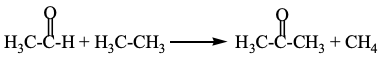.

An isodesmic reaction is one in which the total number of each type of chemical bond is the same in both reactants and products. Because of this equality in bond type, results of calculations using such a reaction should benefit from cancellation of errors.

## Building and minimizing the molecule

--> In the following cell, write code that will use rkdit and PySCF to build and minimize a model of acetone (`CC(=O)C`), methane (`C`), acetaldehyde (`CC=O`), or ethane (`CC`) and print out its energy. Use the restricted-shell Hartree-Fock level of theory and STO-3G or 6-31G* basis set. You may copy code and edit from other exercises. At the end of the cell, you should have (at least) two variables defined: `gto_mol_min: pyscf.gto.mole.Mole` and `mf_min: pyscf.scf.hf.RHF`.

The following code will take `gto_min_mol` and `mf` and perform an additional minimization with DFT. Only run this cell block if you actually want to run DFT.

In [ ]:
mf = dft.RKS(gto_mol_min)
mf.xc = 'b3lyp'
gto_mol_min = optimize(mf)
mf_min = scf.RHF(gto_mol_min).run()
print(f'DFT energy: {mf_min.e_tot} Hartrees')

## Harmonic analysis

Besides predicting the normal modes and peaks in infrared spectra, harmonic analysis can also be used to estimate thermodynamic properties.

In [ ]:
hess = hessian.RHF(mf_min).kernel()
harmonic_analysis_results = thermo.harmonic_analysis(gto_mol_min, hess)
thermo_results = thermo.thermo(mf_min, harmonic_analysis_results['freq_au'], 298.15, 101325)
thermo.dump_thermo(gto_mol_min, thermo_results)

--> Complete the table below for the enthalpy (in kJ/mol). For DFT B3LYP use the 6-31G* basis set.

 |              | HF 6-31G* | DFT B3LYP |
 | ------------ | --------- | --------- |
 | Acetone      |           |           |
 | Methane      |           |           |
 | Acetaldehyde |           |           |
 | Ethane       |           |           |
 | $\Delta H_r$ |           |           |

--> Complete the table below for the Gibbs free energy (in kJ/mol). For DFT B3LYP use the 6-31G* basis set.

 |              | HF 6-31G* | DFT B3LYP |
 | ------------ | --------- | --------- |
 | Acetone      |           |           |
 | Methane      |           |           |
 | Acetaldehyde |           |           |
 | Ethane       |           |           |
 | $\Delta G_r$ |           |           |

--> Is the reaction predicted to be spontaneous?